# TP Architecture des Systèmes Embarquées

Dans ce TP nous allons créer et lancer l'apprentissage d'un modèle de classification d'images. Le modèle prendra une image en entrée et en sortie, prédit la classe de l'objet dans l'image. Ces taches sont très fréquents dans les systèmes autonomes comme les voitures afin de détecter les obstacles (piétons, autres voitures, paneaux de signalisations) et les drones de surveillance.

Les algorithmes de machine learning domine le monde d'intélligence artificielle récemment. Pour cela, nous allons utiliser un modèle de classification basé sur le machine learning. Pour platforme logicielle, nous allons utiliser PyTorch.

## Préparation de données

La première étape de conception d'un modèle est l'apprentissage. Dans cette étape, nous allons fournir un ensemble d'images à l'algorithme. Ces images sont étiqueté par un humain. L'ordinateur essaira de trouver la relation entre l'image en entrée et la prédiction qu'il doit donner plus tard.

1. Nous allons utiliser une base de données CIFAR10, disponible en ligne. Pour simplifier son importation, nous allons utiliser `torchvision`, une librairie de torch permettant de charger les données. D'abord, il faut importer ces librairie dans Jupyter.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

Ces prochaines lignes servent à importer la base de donnés et normaliser les images dedans. Cette étape est importante pour améliorer la qualité des résultats finaux.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12998462.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Dans la base de données, les classes sont codé par un entier de 0 à 9. Pourquoi cette codification?**

Pour des raisons d'affichage, nous allons déclarer les 10 classes sous forme d'un tableau de chaine de caractères.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Nous allons afficher un extrait de cette base de donnés. Pour cela, nous utilisons `matplotlib`.

La fonction `imshow` permet de restaurer l'image originale à partir d'une image normalisé et l'afficher dans le carnet.

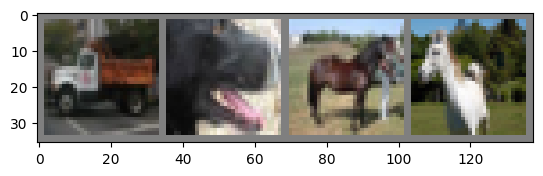

truck   dog horse horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Apprentissage

L'étape suivante permet de définir le modèle de classification. Un modèle est une suite d'opérations organisé dans un pipeline. Un ensemble d'opération est appelé couche. Chaque couche prends la sortie de la précédente et fourni l'entré de la couche suivante. L'image est l'entrée de la première couche et la sortie de la dernière est la classe prédite pour l'objet.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Un modèle a besoin d'un optimisateur qui vas essayer de minimiser son erreur. L'érreur est la différence entre ce qu'on veut avoir (le code de la classe entre 0 et 9) et ce que le modèle sort (un autres entier entre 0 et 9). Plus cette erreur est petite, mieux le réseaux reconnais les images.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Une fois que tout est prêt, l'apprentissage commence. C'est une étape très gourmande en calcul. Nous allons passer les images au modèles en modifiant les parameters de celui ci après chaque passage. Sachant que la base de donnés contient 60000 images, toutes ces images doivent être passé au classifieur.

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.218
[1,  4000] loss: 1.859
[1,  6000] loss: 1.671
[1,  8000] loss: 1.590
[1, 10000] loss: 1.520
[1, 12000] loss: 1.479
[2,  2000] loss: 1.413
[2,  4000] loss: 1.371
[2,  6000] loss: 1.357
[2,  8000] loss: 1.330
[2, 10000] loss: 1.305
[2, 12000] loss: 1.278
Finished Training


# Inférence

La deuxième phase du Machine Learning est l'inférence. Une fois que le modèle est entrainé (phase apprentissage), il est prét pour générer des prédictions sur des nouveaux images.
Nous allons utiliser les images de la base de test. C'est une portion de la base de données qui n'est pas utilisé pour l'apprentissage.
D'abord, nous allons visualer une portion de ces images.

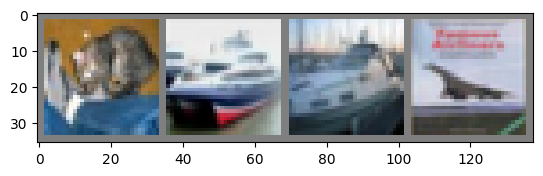

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Nous allons charger le modèle que nous avons précédemment enregister après l'apprentissage.

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Il ne reste qu'a lancer l'inférences sur les images que nous avons afficher précédemment.

In [ ]:
outputs = net(images)

On affiche les résultats pour comparer à la référence.

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


Nous pouvons bien évidemment tester sur d'autres images. Pour cela, nous avons le dossier `test_data` dans lequel nous allons mettre ces images.
Télécharger une photo d'un objet de l'une des clases sur lesquels nous avons entrainé le modèle et mettez la dans le dossier `test_data`.
La taille des images doit être (32 * 32) avec 3 channels: R, G et B. Ce sont les paramètres que nous avons mis dans la première couche du réseaux en haut.

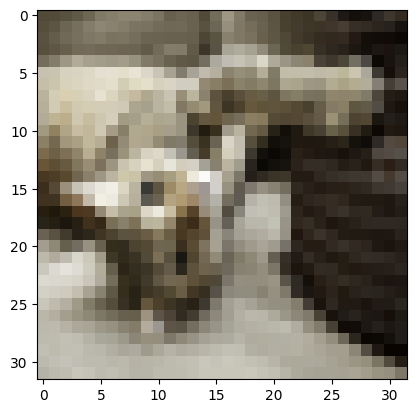

GroundTruth:      d o g


IsADirectoryError: [Errno 21] Is a directory: 'test_data/.ipynb_checkpoints'

In [ ]:
import os
from PIL import Image

files = os.listdir('test_data')
for f in files:
  img = Image.open('test_data/'+f)
  resized = img.resize((32, 32))
  normalized = transform(np.array(resized))
  imshow(normalized)
  net_inp = normalized.reshape(1, 3, 32, 32)
  out = net(net_inp)
  _, predicted = torch.max(out, 1)
  print('GroundTruth: ', ' '.join('%5s' % classes[predicted[0]]))



Pour calculer la précision du modèle nous allons le tester sur un grand nombre d'images dont on connais au paravent les classes. La précision est alors le nombre d'image correctement classifié sur le nombre total d'images.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Précision du modèle sur 12000 images: %d %%' % (
    100 * correct / total))

Précision du modèle sur 10000 images: 54 %


# Sur GPU! Pourquoi et Comment ?

Dans cette étape nous allons porter le modèle sur GPU. Avant de faire, nous allons calculer quelques temps d'exécution. On vous donne le code suivant qui permet de calculer le temps d'exécution d'une, ou plusieurs, instructions.

In [ ]:
import time
start = time.time()
# ATTENTION: Pour calculer le temps d'exécution, il faut pas laisser les affichages et les entrés sorties
# Lors du déploiement, un algorithme ne communiquer ces sortie que pour actionner des modules ou prendre des décision
a = 0
for i in range(10000000):
  a+=i
print(a)
end = time.time()
print("Temps d'exécution: {} secondes".format(round(end-start, 4)))

**En utilisant cette technique, ecrivez deux fonctions `temps_cpu_app` et `temps_cpu_inf` pour estimer le temps d'exécuter de l'apprentissage et de l'inférence.**

N'oubliez pas de commentez les lignes d'affichage. Pour l'inférence, il ne faut considérer que le temps que le modèle est en train de s'exécuter. Les temps de redimensionnement et de normalisation de l'image ne doivent pas être prises en compte.

Attention: Le temps d'exécution pour les petites taches (comme l'inférence d'une image) peux varier. **Comment vérifier? Pourquoi cette variation? Que proposez vous pour avoir un temps plus précis?**

## Porter le modèle sur GPU

Toute algorithme s'exécute sur le CPU sauf si une autre plateforme est précisé. Si le temps d'exécution n'est pas satisfaisant pour les besoin de l'application, il faut porter le modèle sur des architecture plus puissants. Dans notre cas, Colab offre 2 types de platformes: les GPUs et les TPUs. Dans ce TP nous allons voir comment utiliser un GPU et quels sont les gains que l'on vas avoir.

Pour lister les accélérateurs existants on utilise les instruction suivantes.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

Assurez vous d'avoir un résultat `cuda:0`. Si c'est pas le cas, changer le mode d'exécution dans "Exécution ==> Mode d'exécution" au GPU. Vous trouverez une liste déroulante contenant les options: None pour CPU, GPU et TPU. Réexécuter l'étape précédente jusqu'a ce que vous obtenez l'affiche demandé. En réalité, si un GPU est installé sur la machine, nous devons être capable de l'utiliser. Vu que Colab est une platforme virtuelle, le choix du matérielle est fait de cette façon.

Jusqu'a maintenent, toute les opérations que nous avons fait ont été exécuté sur le CPU. Les paramètres du modèels sont stocké dans la mémoire centrale (RAM). Cette mémoire n'est physiquement connecté qu'au CPU. Le GPU, ayant une mémoire physique à lui, ne poura pas travailler sur ces valeurs. Il faut copier toute variable à la mémoire interne du GPU afin que l'on puisse l'utiliser. Pour cela, l'instruction suivante permet de copier le modèle au GPU.

In [ ]:
net.to(device)

**Relancer les étapes précédentes, notamment inférence et apprentissage, en utilisant le GPU. Faites deux autres fonctions `temps_gpu_app` et `temps_gpu_inf` pour le temps d'exécution apprentissage et inférence sur GPU.**

Attention! Les entrée doivent aussi être en GPU pour que l'exécution puisse se faire. Pour l'apprentissage par exemple, il faut remplacer la ligne `inputs, labels = data` par `inputs, labels = data[0].to(device), data[1].to(device)` pour que le GPU puissent lire les entrées.

**Générez plusieurs modèles (10) en changent le nombre de couches, la taille de filtres dans chaque couche, la taille de l'image en entrés, etc. Pour chaque modèle calculer la précision de celui-ci, le temps d'exécution pour l'inférence et pour l'apprentissage.**

**Tracer deux courbes à l'aide de `matplotlib` qui affichent la variation du temps d'exécution entre le CPU et le GPU pour chaque modèle.**

In [ ]:
import random
def temps_cpu_app():
  return random.random()
def temps_cpu_inf():
  return random.random()
def temps_gpu_app():
  return random.random()
def temps_gpu_inf():
  return random.random()

import matplotlib.pyplot as plt

t_cpu_app = []
t_cpu_inf = []
t_gpu_app = []
t_gpu_inf = []
x = []
for i in range(10):
  t1 = temps_cpu_app()
  t2 = temps_cpu_inf()
  t3 = temps_gpu_app()
  t4 = temps_gpu_inf()
  t_cpu_app.append(t1)
  t_cpu_inf.append(t2)
  t_gpu_app.append(t3)
  t_gpu_inf.append(t4)
  x.append(i)

plt.plot(x, t_cpu_app, label='CPU APP')
plt.plot(x, t_gpu_app, label='GPU APP')
plt.legend()
plt.show()
plt.plot(x, t_cpu_inf, label='CPU INF')
plt.plot(x, t_gpu_inf, label='GPU INF')
plt.legend()
plt.show()